In [3]:
import itertools
import math
import cmath
import gsd.hoomd
import hoomd
import numpy as np
import freud
import matplotlib
import warnings
import fresnel
import IPython
import io
import packaging.version
import PIL
%matplotlib inline
matplotlib.style.use('ggplot')
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [7]:
import math
import cmath
import cairo
import random

divisions = 2  
zoom = "out"  
scale = {"in": 1, "out": 2}[zoom]
resolution = (1080, 1080) 
colors_input = ("red", "blue", "grey")  
filename = "test.png"
vertices_filename = "vertices.txt"

color_map = {
    "random": lambda: [random.random(), random.random(), random.random()],
    "red": [0.8, 0.3, 0.3],
    "orange": [0.9, 0.6, 0.3],
    "yellow": [0.6, 0.9, 0.3],
    "green": [0.3, 0.9, 0.6],
    "blue": [0.3, 0.6, 0.9],
    "purple": [0.8, 0.3, 0.6],
    "grey": [0.2, 0.2, 0.2],
    "brown": [0.6, 0.3, 0.1],
    "black": [0, 0, 0],
    "white": [1, 1, 1]
}

colors = [color_map.get(c, color_map["black"]) for c in colors_input]
r1, r2 = resolution
phi = (5 ** 0.5 + 1) / 2 

surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, r1, r2)
ctx = cairo.Context(surface)
ctx.scale(max(r1, r2) / scale, max(r1, r2) / scale)
ctx.translate(0.5 * scale, 0.5 * scale)  

triangles = []
base = 5
for i in range(base * 2):
    v2 = cmath.rect(1, (2 * i - 1) * math.pi / (base * 2))
    v3 = cmath.rect(1, (2 * i + 1) * math.pi / (base * 2))
    v2, v3 = (v3, v2) if i % 2 == 0 else (v2, v3) 
    triangles.append(("thin", 0, v2, v3))

for _ in range(divisions):
    new_triangles = []
    for shape, v1, v2, v3 in triangles:
        if shape == "thin":
            p1 = v1 + (v2 - v1) / phi
            new_triangles += [("thin", v3, p1, v2), ("thicc", p1, v3, v1)]
        else:
            p2, p3 = v2 + (v1 - v2) / phi, v2 + (v3 - v2) / phi
            new_triangles += [("thicc", p3, v3, v1), ("thicc", p2, p3, v2), ("thin", p3, p2, v1)]
    triangles = new_triangles

def draw_triangles(shape_type, color_index):
    ctx.set_source_rgb(*colors[color_index])
    for shape, v1, v2, v3 in triangles:
        if shape == shape_type:
            ctx.move_to(v1.real, v1.imag)
            ctx.line_to(v2.real, v2.imag)
            ctx.line_to(v3.real, v3.imag)
            ctx.close_path()
    ctx.fill()

draw_triangles("thin", 0)
draw_triangles("thicc", 1)

ctx.set_line_width(divisions ** -3 if divisions > 3 else divisions ** -5)
ctx.set_line_join(cairo.LINE_JOIN_ROUND)
ctx.set_source_rgb(*colors[2])
for _, v1, v2, v3 in triangles:
    ctx.move_to(v2.real, v2.imag)
    ctx.line_to(v1.real, v1.imag)
    ctx.line_to(v3.real, v3.imag)
ctx.stroke()

surface.write_to_png(filename)

with open(vertices_filename, "w") as f:
    for shape, v1, v2, v3 in triangles:
        f.write(f"Shape: {shape}\n")
        f.write(f"Vertex 1: ({v1.real:.3f}, {v1.imag:.3f})\n")
        f.write(f"Vertex 2: ({v2.real:.3f}, {v2.imag:.3f})\n")
        f.write(f"Vertex 3: ({v3.real:.3f}, {v3.imag:.3f})\n\n")

print(f"Image saved as {filename}")
print(f"Vertices saved as {vertices_filename}")


Image saved as test.png
Vertices saved as vertices.txt


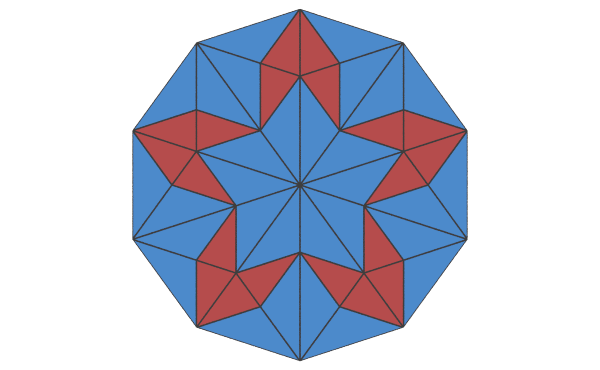

In [8]:
def convert_colors_to_linear(colors):
    return fresnel.color.linear(np.array(colors))

color_map = {
    "red": (0.8, 0.3, 0.3),
    "blue": (0.3, 0.6, 0.9),
    "grey": (0.2, 0.2, 0.2),
}

colors = {
    "thin": color_map["red"],   
    "thicc": color_map["blue"],   
    "outline": color_map["grey"],  
}

linear_colors = {shape: convert_colors_to_linear(color) for shape, color in colors.items()}

def parse_shapes(file_path):
    shapes = [] 
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
        current_shape = None
        current_vertices = []
        
        for line in lines:
            line = line.strip()
            if line.startswith("Shape:"):
                if current_shape and current_vertices:
                    shapes.append((current_vertices, current_shape))
                
                current_shape = line.split(": ")[1]  
                current_vertices = []  
            
            elif line.startswith("Vertex"):
                vertex = line.split(": ")[1].strip()[1:-1]
                x, y = map(float, vertex.split(", "))
                current_vertices.append((x, y))
        
        if current_shape and current_vertices:
            shapes.append((current_vertices, current_shape))
    
    return shapes

scene = fresnel.Scene()

shapes = parse_shapes(vertices_filename)

for vertices, shape_type in shapes:
    shape_color = linear_colors.get(shape_type, np.array([0, 0, 0]))  
    
    shape_material = fresnel.material.Material(
        color=shape_color.flatten(), 
        roughness=0.5
    )

    outline_material = fresnel.material.Material(
        color=linear_colors["outline"].flatten()
    )

    fresnel.geometry.Polygon(
        scene,
        vertices,
        position=(0, 0),
        angle=0,
        color=shape_color.flatten(),
        rounding_radius=0,
        material=shape_material,
        outline_material=outline_material,  
        outline_width=0.005  
    )

scene.camera = fresnel.camera.Orthographic.fit(scene)

fresnel.preview(scene)